Para realizar la regresión logística, primero es necesario limpiar la base de datos. La limpieza que se muestra a continuación proviene de un trabajo previo titulado **Reporte sobre los habitantes por vivienda usando los datos del ENIF**. Para más información, puedes consultar este [link](https://chuyhawk59.github.io/Reporte_sobre_los_habitantes_por_vivienda_usando_los_datos_del_ENIF/).
La única modificación realizada fue cambiar el nombre de la variable `tiene_auto_2` a `tiene_auto`, con el fin de predecir la variable en sentido positivo y no en negativo.

No hay huecos en ninguna de las columnas
Columnas a eliminar por prueba de colinealidad: {'est_dis', 'num_auto', 'upm_dis', 'llaveviv', 'tipo_internet'}


C:\Users\jesus\AppData\Local\Temp\ipykernel_28324\2513595161.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(cor, cmap="coolwarm", annot=cor.applymap(lambda x: f"{x:.2f}" if x >= 0.8 else " "), fmt="", cbar=True)


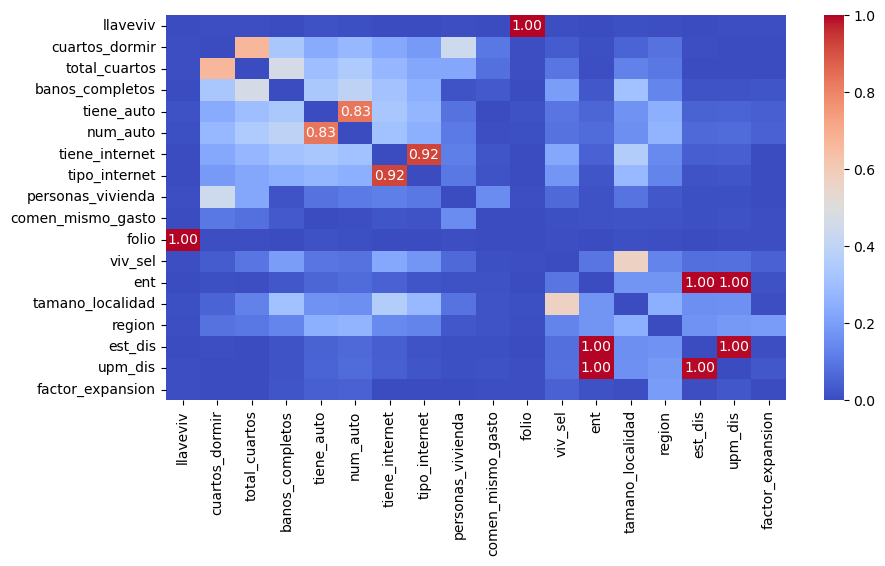

Dimensiones del archivo antes de separar (13303, 13)
Dimensiones del archivo despues de separar: (13303, 52)


C:\Users\jesus\AppData\Local\Temp\ipykernel_28324\2513595161.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)


0        0
1        0
2        0
3        0
4        1
        ..
13298    0
13299    1
13300    0
13301    1
13302    1
Name: tiene_auto_2, Length: 13303, dtype: int64

Base de datos solucionada
    cuartos_dormir  total_cuartos  banos_completos  personas_vivienda  folio  \
0               2              4                1                  3      1   
1               1              3                1                  1      2   
2               2              4                1                  2      3   
3               1              4                1                  1      4   
4               3              6                2                  4      5   
5               2              4                1                  4      6   
6               1              3                0                  6      7   

   viv_sel  factor_expansion  tiene_internet_2  tamano_localidad_2  \
0        1               613                 0                   0   
1       10              1811  

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
df = pd.read_csv("conjunto_de_datos_tvivienda_enif2024.csv")
df = df.rename(columns={
    "p0_1": "cuartos_dormir",
    "p0_2": "total_cuartos",
    "p0_3": "banos_completos",
    "p0_4_1": "tiene_auto",
    "p0_4_1a": "num_auto",
    "p0_4_2": "tiene_internet",
    "p0_4_2a": "tipo_internet",
    "p1_1": "personas_vivienda",
    "p1_2": "comen_mismo_gasto",
    "p1_3": "num_hogares",
    "tloc": "tamano_localidad",
    "fac_viv": "factor_expansion"
})

df = df.drop('num_hogares',axis = 1)
df.loc[(df["tiene_auto"] == 2) & (df["num_auto"].isna()), "num_auto"] = 0
df.loc[(df["tiene_internet"] == 2) & (df["tipo_internet"].isna()), "tipo_internet"] = 0

if all(df.isna()):
    print("No hay huecos en ninguna de las columnas")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

%matplotlib inline


cor = df.corr().abs()  
np.fill_diagonal(cor.values, 0)
sns.heatmap(cor, cmap="coolwarm", annot=cor.applymap(lambda x: f"{x:.2f}" if x >= 0.8 else " "), fmt="", cbar=True)
# Obtener los índices (i,j) de la posición del valor máximo
i, j = np.unravel_index(cor.values.argmax(), cor.shape)
y = df.tiene_auto

corr_matrix = df.corr().abs()
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.8:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            if abs(df[colname1].corr(y)) > abs(df[colname2].corr(y)):
                to_drop.add(colname2)
            else:
                to_drop.add(colname1)
print("Columnas a eliminar por prueba de colinealidad:", to_drop)
df = df.drop(to_drop,axis = 1)

plt.show()

print("Dimensiones del archivo antes de separar",df.shape)
cols_cualitativas = ["tiene_auto", "tiene_internet", "tamano_localidad", "region", "comen_mismo_gasto", "tamano_localidad","ent"]
for col in cols_cualitativas:
    dummy = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df, dummy], axis=1)

df = df.drop(columns=cols_cualitativas)
print("Dimensiones del archivo despues de separar:",df.shape)
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)
print(df.tiene_auto_2)
df["tiene_auto"] = ~df["tiene_auto_2"].astype(bool)
df["tiene_auto"] = df["tiene_auto"].astype(int)
df = df.drop("tiene_auto_2", axis=1)

print("\nBase de datos solucionada\n",df.head(7))

Usamos la función `train_test_split` para dividir los datos en un 80% para entrenamiento y un 20% para prueba; después copiamos los conjuntos de características y les añadimos la variable objetivo **tiene_auto** para conformar los DataFrames **train_df** y **test_df**. Para comprobar la distribución de clases en cada conjunto, se definió la función `print_props`, que calcula el número de observaciones y el porcentaje de cada clase (0 y 1), lo que permite verificar que las proporciones se mantienen similares en los datos originales, de entrenamiento y de prueba, garantizando así que la separación no genere un sesgo en la variable a predecir. Al ver los resultados impresos se observa que la separacion no provoca ningun sesgo. 

In [70]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["tiene_auto"])
y = df["tiene_auto"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
)

train_df = X_train.copy()
train_df["tiene_auto"] = y_train.values

test_df = X_test.copy()
test_df["tiene_auto"] = y_test.values

# Función auxiliar para imprimir proporciones
def print_props(nombre, serie_clase):
    pct = (serie_clase.value_counts(normalize=True) * 100).sort_index()
    n = len(serie_clase)
    print(f"{nombre} (n={n}):")
    for clase, p in pct.items():
        print(f"  Clase {clase}: {p:.2f}%")
    print()

# Imprimir proporciones
print_props("Datos originales", y)
print_props("Entrenamiento", y_train)
print_props("Prueba", y_test)

Datos originales (n=13303):
  Clase 0: 49.33%
  Clase 1: 50.67%

Entrenamiento (n=10642):
  Clase 0: 49.32%
  Clase 1: 50.68%

Prueba (n=2661):
  Clase 0: 49.34%
  Clase 1: 50.66%



Ahora creamos un modelo de **regresión logística** con un máximo de 1000 iteraciones con la funcion `LogisticRegression()`. Luego, con la función `cross_val_score`, se aplica validación cruzada de **10 folds** sobre los datos de entrenamiento. Esto significa que los datos de entrenamiento se dividen en 10 partes: en cada iteración, 9 se usan para entrenar y 1 para evaluar, repitiendo el proceso hasta que todas las partes se hayan usado como prueba. El resultado **cv_scores** es un vector con la exactitud obtenida en cada fold, lo que permite observar cómo varía el rendimiento del modelo entre diferentes particiones. Finalmente, se calcula la **media de exactitud**, que refleja el desempeño promedio esperado del modelo, y la **desviación estándar**, que indica qué tanto varían los resultados entre los folds. Al ver nuestros resultados podemos concluir que se espera que tenga buen desempeño con la confianza de que los datos no varian mucho.

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=5000, solver="liblinear")

cv_scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="accuracy")

print("Exactitud por fold:", cv_scores)
print("Media de exactitud:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Exactitud por fold: [0.71549296 0.71455399 0.68703008 0.70300752 0.70676692 0.70112782
 0.70488722 0.71616541 0.71992481 0.72932331]
Media de exactitud: 0.7098280031063574
Desviación estándar: 0.011190805309170456


Se entrena el modelo con la funcion `log_reg.fit` y luego se obtiene, para cada instancia de prueba, la **probabilidad de ser clase 1**. La función `plot_confusion` recibe las etiquetas reales, los puntajes probabilísticos y un **umbral** para convertir las probabilidades en predicciones binarias. Con esas predicciones se construye la **matriz de confusión** y calcula tres métricas: **accuracy** (Proporción total de aciertos), **sensibilidad** (Qué tanto detectas los positivos) y **especificidad** (Qué tanto detectas los negativos). Finalmente grafica un heatmap cuadrado de la matriz y muestra las métricas en el título. El bucle prueba **tres umbrales** (0.3, 0.5, 0.7): con umbral de 0.3 sube la sensibilidad pero baja la especificidad, con umbral de 0.7 pasa lo contrario y el 0.5 nos da resultados bastantes buenos, esto porque las metricas son relativamente altas.

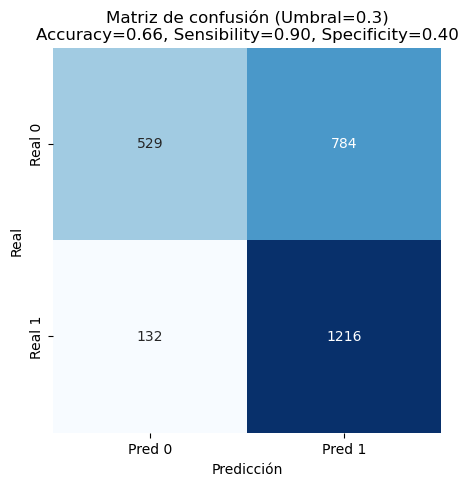

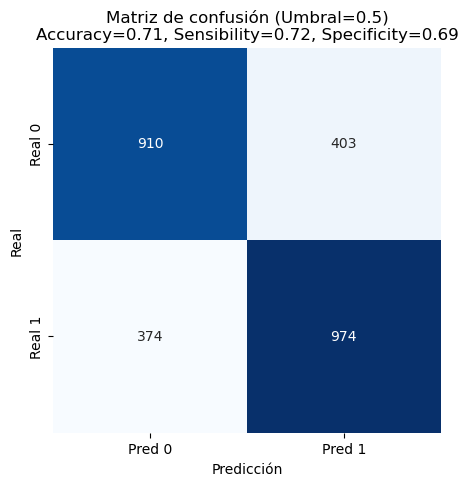

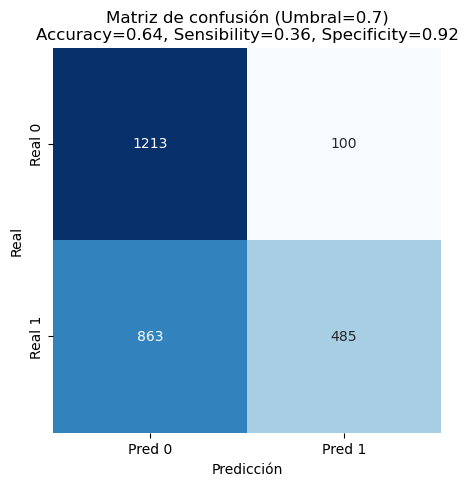

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

log_reg.fit(X_train, y_train)
y_proba = log_reg.predict_proba(X_test)[:, 1]

def plot_confusion(y_true, y_scores, umbral):
    y_pred = (y_scores >= umbral).astype(int)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    
    acc = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred, pos_label=1)
    spec = recall_score(y_true, y_pred, pos_label=0)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["Real 0","Real 1"])
    plt.title(f"Matriz de confusión (Umbral={umbral})\nAccuracy={acc:.2f}, Sensibility={sens:.2f}, Specificity={spec:.2f}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

for umbral in [0.3, 0.5, 0.7]:
    plot_confusion(y_test, y_proba, umbral)

Para graficar la curva ROC se utiliza la función `roc_curve`, que devuelve los puntos necesarios de la gráfica junto con los umbrales probados. Después, con la función `roc_auc_score`, se calcula el área bajo la curva (AUC). Mientras más cerca esté este valor de **1**, mejor es la capacidad del modelo para distinguir entre las clases. Nuestro modelo tiene un AUC lo suficientemente cerca de 1 para decir que el modelo distingue bien entre las clases.

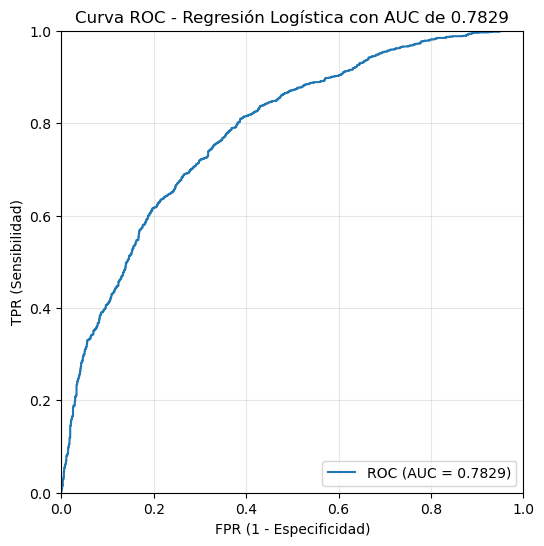

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, umbrales = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.xlim([0, 1]); plt.ylim([0, 1])
plt.xlabel("FPR (1 - Especificidad)")
plt.ylabel("TPR (Sensibilidad)")
plt.title(f"Curva ROC - Regresión Logística con AUC de {auc:.4f}")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', 'box')
plt.show()


In [79]:
coef = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": log_reg.coef_[0]
})
coef["Exp(Coef)"] = np.exp(coef["Coeficiente"])

aumentan = []
disminuyen = []
neutras = []

for i, row in coef.iterrows():
    exp_val = row["Exp(Coef)"]
    variable = row["Variable"]
    
    if exp_val > 1.05:
        aumentan.append(variable)
    elif exp_val < 0.95:
        disminuyen.append(variable)
    else:
        neutras.append(variable)

print("Variables que AUMENTAN la probabilidad:\n", aumentan)
print("Variables que DISMINUYEN la probabilidad:\n", disminuyen)
print("Variables que NO APORTAN o APORTAN POCO:\n", neutras)

Variables que AUMENTAN la probabilidad:
 ['total_cuartos', 'banos_completos', 'tamano_localidad_3', 'tamano_localidad_4', 'tamano_localidad_3', 'tamano_localidad_4', 'ent_2', 'ent_3', 'ent_6', 'ent_8', 'ent_12', 'ent_13', 'ent_14', 'ent_15', 'ent_23', 'ent_26', 'ent_28', 'ent_32']
Variables que DISMINUYEN la probabilidad:
 ['tiene_internet_2', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'comen_mismo_gasto_2', 'ent_4', 'ent_7', 'ent_9', 'ent_10', 'ent_11', 'ent_16', 'ent_17', 'ent_18', 'ent_21', 'ent_22', 'ent_24', 'ent_25', 'ent_27', 'ent_29', 'ent_30', 'ent_31']
Variables que NO APORTAN o APORTAN POCO:
 ['cuartos_dormir', 'personas_vivienda', 'folio', 'viv_sel', 'factor_expansion', 'tamano_localidad_2', 'tamano_localidad_2', 'ent_5', 'ent_19', 'ent_20']


Los coeficientes de la regresión logística se interpretan a través de su valor exponencial **(Exp(Coef))**, que indica cómo cambia la probabilidad de que ocurra la salida cuando la variable aumenta una unidad:

* Si Exp(Coef) > 1, la variable aumenta la probabilidad de tener auto.

* Si Exp(Coef) < 1, la variable disminuye la probabilidad de tener auto.

* Si Exp(Coef) ≈ 1, la variable aporta poco o nada a la predicción.

En este modelo, por ejemplo, más cuartos y baños incrementan la probabilidad de tener auto (Exp(Coef) > 1). En contraste, no tener internet o algunas regiones/entidades reducen esa probabilidad (Exp(Coef) < 1). Finalmente, variables como folio o factor_expansion presentan valores cercanos a 1, lo que significa que apenas influyen en el resultado.